<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day3/unet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a U-net

The [U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a very popular model architecture for segmentation in bioimage analysis.
Here, we will train a 2D U-net for nuclei segmentation, using data from the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

## The libraries

In [186]:
%matplotlib inline
%load_ext tensorboard
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

from pathlib import Path

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [187]:
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
from utils import EMDataset, split_with_overlap, stack_chan

## Data loading and preprocessing

In [189]:
data_dir = Path(r"/g/kreshuk/buglakova/data/cryofib")
images_dir = data_dir / "F107_bin2_619-639_frames" / "train"
labels_dir = data_dir / "corrected_labels" / "train"

In [190]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

In [191]:
image = list(images_dir.glob("*.tiff"))[0]
mask = list(labels_dir.glob("*.tiff"))[0]

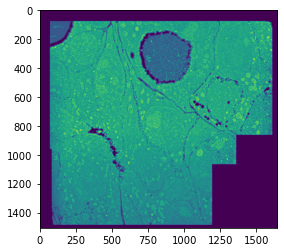

In [192]:
show_one_image(image)

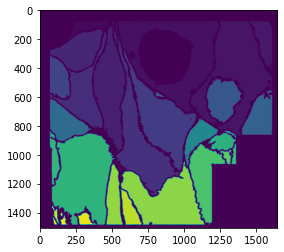

In [193]:
show_one_image(mask)

In [194]:
image = imageio.imread(list(images_dir.glob("*.tiff"))[5])
mask = imageio.imread(list(labels_dir.glob("*.tiff"))[5])

In [195]:
tile_layout, ind_min, ind_max = split_with_overlap(image, tile_size=(1024, 1024), overlap=0.1)

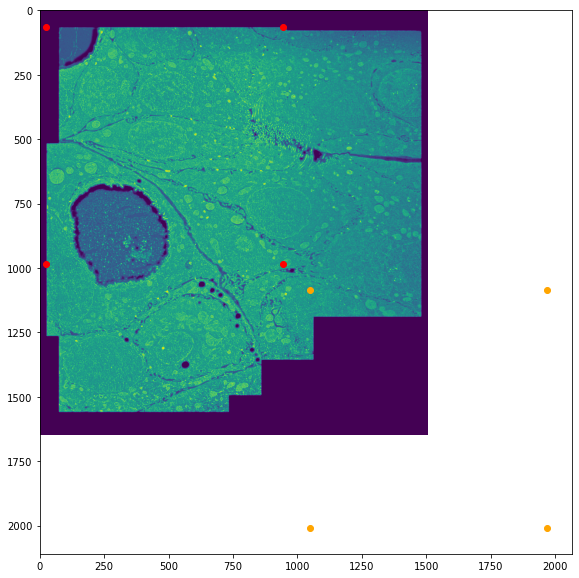

In [196]:
plt.figure(figsize=(10, 10))
plt.imshow(image.T)
plt.scatter(ind_min[0, :], ind_min[1, :], c="r")
plt.scatter(ind_max[0, :], ind_max[1, :], c="orange")

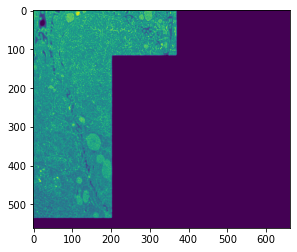

In [197]:
n = -1
plt.imshow(image[ind_min[:, n][0]:ind_max[:, n][0], ind_min[:, n][1]:ind_max[:, n][1], ...])

Load the dataset and visualize it with a simple function:

In [198]:
tile_size = (512, 512)

In [199]:
train_images_dir = data_dir / "F107_bin2_619-639_frames" / "train"
train_labels_dir = data_dir / "corrected_labels" / "train"
train_data = EMDataset(train_images_dir, train_labels_dir, tile_size=tile_size)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)

In [200]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0])                     # show the image
    axarr[1].imshow(mask[0])                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    plt.show()

Image size is {torch.Size([512, 512])}


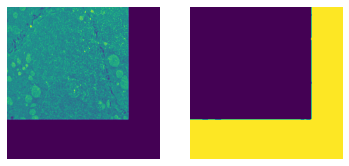

In [201]:
show_random_dataset_image(train_data)

And the same for the validation data:

In [202]:
test_images_dir = data_dir / "F107_bin2_619-639_frames" / "test"
test_labels_dir = data_dir / "corrected_labels" / "test"
test_data = EMDataset(test_images_dir, test_labels_dir, tile_size=tile_size)
val_loader = DataLoader(test_data, batch_size=1)

Image size is {torch.Size([512, 512])}


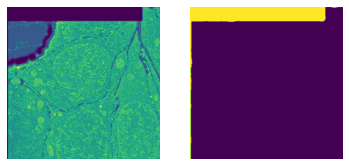

In [204]:
show_random_dataset_image(test_data)

## Load model and predict for all images

In [235]:
data = EMDataset(images_dir, labels_dir)

In [236]:
model_path = "models/unet.pt"

In [237]:
data.predict_boundaries(model_path)

GPU is available


  0%|          | 0/9 [00:00<?, ?it/s]

[74 65]


 11%|█         | 1/9 [00:01<00:09,  1.15s/it]

[25 65]


 22%|██▏       | 2/9 [00:02<00:07,  1.13s/it]

[24 64]


 33%|███▎      | 3/9 [00:03<00:06,  1.13s/it]

[24 64]


 44%|████▍     | 4/9 [00:04<00:05,  1.13s/it]

[23 64]


 56%|█████▌    | 5/9 [00:05<00:04,  1.12s/it]

[23 63]


 67%|██████▋   | 6/9 [00:06<00:03,  1.12s/it]

[23 63]


 78%|███████▊  | 7/9 [00:07<00:02,  1.12s/it]

[23 63]


 89%|████████▉ | 8/9 [00:08<00:01,  1.10s/it]

[24 63]


100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


In [238]:
predictions_dir = data_dir / "F107_bin2_619-639_predictions" / "train"
predictions_dir.mkdir(parents=True, exist_ok=True)
data.save_predictions(predictions_dir)

Saving predictions to /g/kreshuk/buglakova/data/cryofib/F107_bin2_619-639_predictions/train


(-0.5, 6587.5, 1505.5, -0.5)

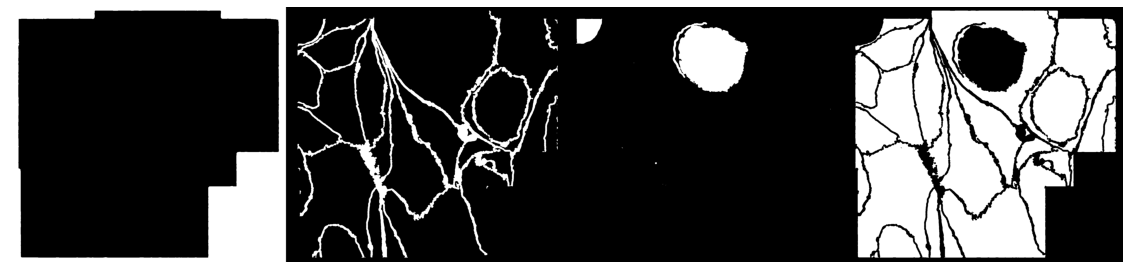

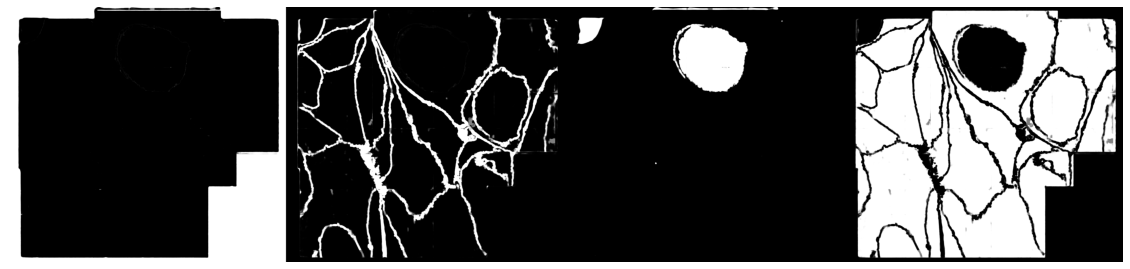

In [240]:
plt.figure(figsize=(20, 5))
mask = np.moveaxis(data.get_mask(3), -1, 0)
plt.imshow(stack_chan(mask[None, ...]), cmap="gray")
plt.axis("off")

plt.figure(figsize=(20, 5))
prediction = np.moveaxis(data.get_mask(3), -1, 0)
plt.imshow(stack_chan(data.stitched_predictions[3][None, ...]), cmap="gray")
plt.axis("off")

## Predict for the whole stack

In [243]:
all_images_dir = "/g/kreshuk/data/from_edoardo/cryoSEM/F107a1_bin2"
all_labels_dir = "/g/kreshuk/data/from_edoardo/cryoSEM/F107a1_bin2"
model_path = "models/unet.pt"
predictions_dir = data_dir / "F107_whole_stack_predictions"
predictions_dir.mkdir(parents=True, exist_ok=True)

In [244]:
data = EMDataset(all_images_dir, all_labels_dir)
data.predict_boundaries(model_path)
data.save_predictions(predictions_dir)

GPU is available


100%|██████████| 1350/1350 [25:33<00:00,  1.14s/it]


Saving predictions to /g/kreshuk/buglakova/data/cryofib/F107_whole_stack_predictions


In [ ]:
plt.figure(figsize=(20, 5))
mask = np.moveaxis(data.get_mask(3), -1, 0)
plt.imshow(stack_chan(mask[None, ...]), cmap="gray")
plt.axis("off")

plt.figure(figsize=(20, 5))
prediction = np.moveaxis(data.get_mask(3), -1, 0)
plt.imshow(stack_chan(data.stitched_predictions[3][None, ...]), cmap="gray")
plt.axis("off")

(-0.5, 6587.5, 1505.5, -0.5)

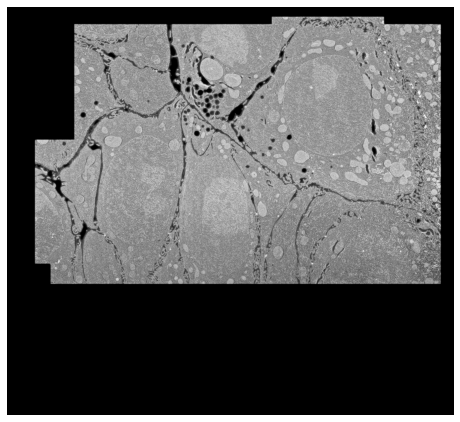

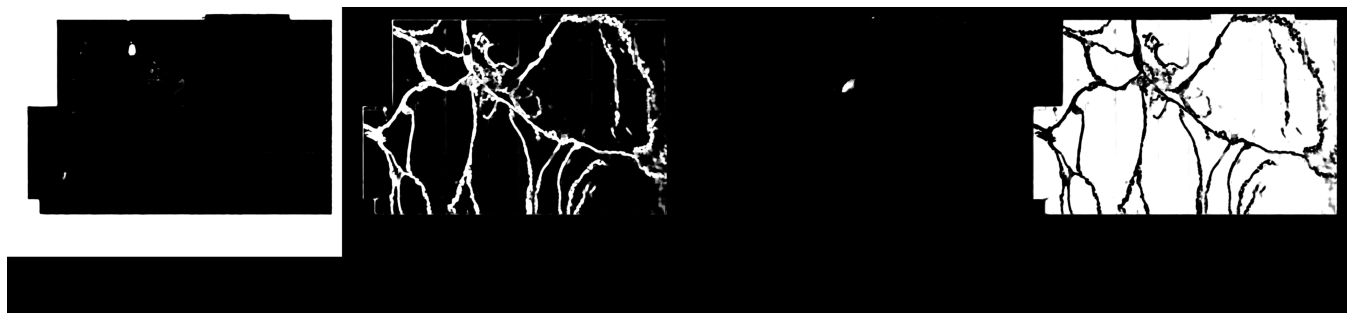

In [248]:
n = 100

plt.figure(figsize=(8, 8))
image = data.get_image(n)
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.figure(figsize=(24, 8))
plt.imshow(stack_chan(data.stitched_predictions[n][None, ...]), cmap="gray")
plt.axis("off")